In [1]:
import ROOT
import os
os.environ["X509_USER_PROXY"] = "/eos/home-t/ttedesch/SWAN_projects/RDataFrame_porting/proxy"

Welcome to JupyROOT 6.24/00


In [2]:
ROOT.ROOT.EnableImplicitMT()

Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 4 threads accordingly


In [3]:
ROOT.gInterpreter.Declare('#include "postselection.h"')

True

In [11]:
# Provided by SWAN, but it could be created manually
#sc

# Use a Spark RDataFrame
#RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame

'''
df = RDataFrame("Events",
                samples,
                npartitions=16,
                sparkcontext=sc)
'''
df = ROOT.RDataFrame("Events", ["root://cms-xrd-global.cern.ch//store/user/apiccine/VBS/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/VBS_SSWW_LL_SM_2017/210420_123836/0000/tree_hadd_1.root",
                                "root://cms-xrd-global.cern.ch//store/user/apiccine/VBS/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/VBS_SSWW_LL_SM_2017/210420_123836/0000/tree_hadd_2.root",
                                "root://cms-xrd-global.cern.ch//store/user/apiccine/VBS/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/VBS_SSWW_LL_SM_2017/210420_123836/0000/tree_hadd_4.root"])
df_goodvertex = df.Filter("Flag_goodVertices && Flag_globalSuperTightHalo2016Filter && Flag_HBHENoiseFilter && Flag_HBHENoiseIsoFilter && Flag_EcalDeadCellTriggerPrimitiveFilter && Flag_BadPFMuonFilter && Flag_ecalBadCalibFilterV2", "Good vertex selection")
df_trigger = df_goodvertex.Filter("HLT_IsoMu27 || HLT_Mu50 || HLT_Ele35_WPTight_Gsf || HLT_Ele32_WPTight_Gsf_L1DoubleEG || HLT_Photon200", "Leptonic trigger")
df_atleast2Jets = df_trigger.Filter("nJet>2", "At least two jets")
df_GoodJets = df_atleast2Jets.Define("GoodJets_idx", "GoodJets(Jet_jetId, Jet_eta, Jet_pt, Jet_puId)")
df_atleast2GoodJets = df_GoodJets.Filter("atleast2GoodJets(GoodJets_idx)", "At least two good jets")
df_VBSjets = df_atleast2GoodJets.Define("VBSJet_idx", "SelectVBSJets_invmass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, GoodJets_idx)")
df_2VBSjets = df_VBSjets.Filter("VBSJet_idx[0] != VBSJet_idx[1]", "2 VBS jets")

##### e/mu + tau process
df_selectElectron = df_2VBSjets.Define("Electron_idx", "SelectElectron(Electron_pt, Electron_eta, Electron_phi, Electron_jetRelIso, Electron_mvaFall17V2Iso_WPL, Electron_mvaFall17V2Iso_WP90, Jet_eta, Jet_phi, VBSJet_idx)")
df_selectMuon = df_selectElectron.Define("Muon_idx", "SelectMuon(Muon_pt, Muon_eta, Muon_phi, Muon_tightId, Muon_looseId, Muon_pfRelIso04_all, Jet_eta, Jet_phi, VBSJet_idx)")
df_atLeast1Lepton = df_selectMuon.Filter("Electron_idx[1] != -1 || Muon_idx[1] != -1", "At least 1 at-least-loose lepton")
df_goodLeptonFamily = df_atLeast1Lepton.Define("GoodLeptonFamily", "DetermineGoodLepton(HLT_IsoMu27, HLT_Mu50, HLT_Ele35_WPTight_Gsf, HLT_Ele32_WPTight_Gsf_L1DoubleEG, HLT_Photon200, HLT_PFHT250, HLT_PFHT350, Electron_idx, Electron_pt, Electron_eta, Electron_mvaFall17V2Iso_WPL, Electron_jetRelIso, Muon_idx, Muon_pt, Muon_eta, Muon_pfRelIso04_all, Muon_looseId)")
df_compatibleLeptons = df_goodLeptonFamily.Filter("GoodLeptonFamily != -1 ", "Filter on leptons") 
df_selectTau = df_compatibleLeptons.Define("Tau_idx", "SelectAndVetoTaus(Tau_pt, Tau_eta, Tau_phi, Tau_idDeepTau2017v2p1VSjet, Tau_idDeepTau2017v2p1VSe, Tau_idDeepTau2017v2p1VSmu, Tau_idDecayModeNewDMs, GoodLeptonFamily, Electron_idx, Electron_eta, Electron_phi, Muon_idx, Muon_eta, Muon_phi, Jet_eta, Jet_phi, VBSJet_idx)")
df_1tau = df_selectTau.Filter("Tau_idx[1] != -1", "Exactly 1 at least loose Tau")
#df_1tau = df_compatibleLeptons

df_plot = df_1tau.Define("Leadingjet_pt", "GetLeading(Jet_pt, VBSJet_idx)")\
                 .Define("Lepton_pt", "GetLepton(Electron_pt, Electron_idx, Muon_pt, Muon_idx, GoodLeptonFamily)")\
                 .Define("SelectedTau_pt", "GetTau(Tau_pt, Tau_idx)")

h = {}

h["Leadingjet_pt"] = df_plot.Histo1D(("Leadingjet_pt", "Leadingjet_pt", 100, 0, 1000),"Leadingjet_pt")
h["Lepton_pt"] = df_plot.Histo1D(("Lepton_pt", "Lepton_pt", 100, 0, 1000),"Lepton_pt")
h["SelectedTau_pt"] = df_plot.Histo1D(("SelectedTau_pt", "SelectedTau_pt", 100, 0, 1000),"SelectedTau_pt")



In [12]:
allCutsReport = df.Report()
allCutsReport.Print()

Good vertex selection: pass=662573     all=662949     -- eff=99.94 % cumulative eff=99.94 %
Leptonic trigger: pass=662573     all=662573     -- eff=100.00 % cumulative eff=99.94 %
At least two jets: pass=661910     all=662573     -- eff=99.90 % cumulative eff=99.84 %
At least two good jets: pass=630658     all=661910     -- eff=95.28 % cumulative eff=95.13 %
2 VBS jets: pass=512668     all=630658     -- eff=81.29 % cumulative eff=77.33 %
At least 1 at-least-loose lepton: pass=410469     all=512668     -- eff=80.07 % cumulative eff=61.92 %
Filter on leptons: pass=192452     all=410469     -- eff=46.89 % cumulative eff=29.03 %
Exactly 1 at least loose Tau: pass=19107      all=192452     -- eff=9.93 % cumulative eff=2.88 %


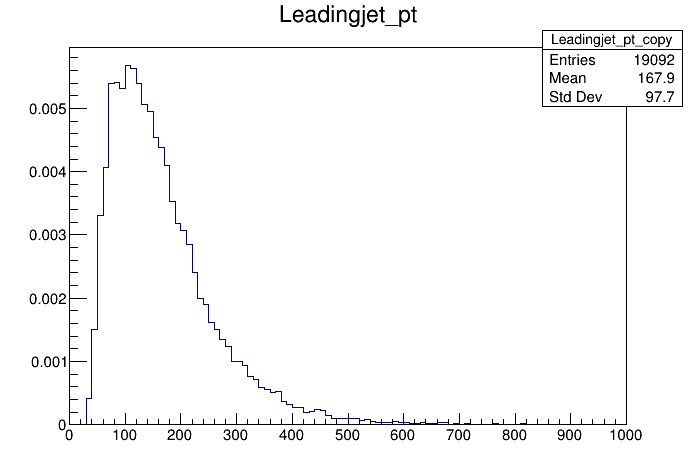

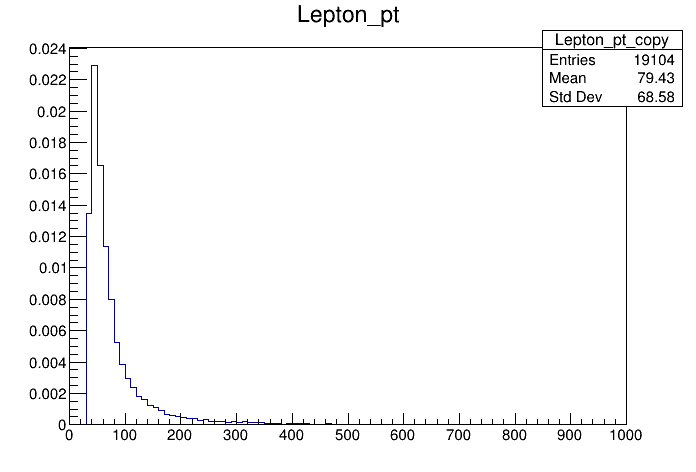

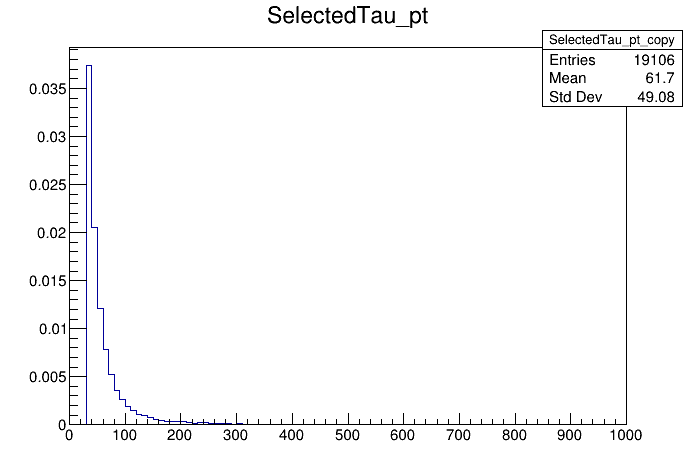

In [13]:
variables = ["Leadingjet_pt","Lepton_pt","SelectedTau_pt",]
canvases = []
legends = []

for i, v in enumerate(variables):
    canvases.append(ROOT.TCanvas())
    variable = variables[i]
    hist = h[variable]
    hist.Scale( 1./hist.Integral(),"WIDTH")
    hist = hist.DrawCopy('HIST')
    canvases[i].Draw()